<a href="https://colab.research.google.com/github/Baroka-wp/dive_ML/blob/master/SimpleConv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
#Importation de bibliothèque
import numpy as np
import pandas as pd
import math
import time
from numpy import array
from scipy import linalg
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP

## [Problème 1] Création d'une classe de couche de convolution unidimensionnelle avec le nombre de canaux limité à un

In [20]:
class SimpleConv1d():
    def forward(self, x, w, b):
        a = []
        for i in range(len(w) - 1):
            a.append((x[i:i+len(w)] @ w) + b[0])
        return np.array(a)
    def backward(self, x, w, da):
        db = np.sum(da)
        dw = []
        for i in range(len(w)):
            dw.append(da @ x[i:i+len(da)])
        dw = np.array(dw)
        dx = []
        new_w = np.insert(w[::-1], 0, 0)
        new_w = np.append(new_w, 0)
        for i in range(len(new_w)-1):
            dx.append(new_w[i:i+len(da)] @ da)
        dx = np.array(dx[::-1])
        return db, dw, dx

## [Problème 2] Calcul de la taille de sortie après convolution unidimensionnelle


In [21]:
def output_size_calculation(n_in, F, P=0, S=1):
  n_out = int((n_in + 2*P - F) / S + 1)
  return n_out

output_size_calculation(100,3)

98

## [Problem 3] Experiment of one-dimensional convolutional layer with small array


In [22]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])


In [23]:
# Forward propagation
simple_conv_1d = SimpleConv1d()
simple_conv_1d.forward(x, w, b)

array([35, 50])

In [25]:
# Backward propagation
delta_a = np.array([10, 20])
simple_conv_1d.backward(x, w, delta_a)

(30, array([ 50,  80, 110]), array([ 30, 110, 170, 140]))

In [26]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])

a = np.empty((2, 3))

indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)

a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

a = a.sum(axis=1)

a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

array([34., 49.])

## [Problème 4] Création d'une classe de couche de convolution unidimensionnelle qui ne limite pas le nombre de canaux


In [27]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [52]:
class CNN1d:
    def __init__(self,W, B, stride=1, pad=0):
        self.W = W
        self.B = B
        self.stride = stride
        self.pad = pad

    def forward(self, X):
        self.FN, self.C, self.FS = self.W.shape 
        self.C, self.S = X.shape
        self.Nout = int(((self.S + 2*self.pad - self.FS) / self.stride) + 1)
        self.reW= self.W.reshape(self.FN,-1).T
        self.output = np.zeros((self.S,self.Nout))
        self.openX = np.zeros((self.Nout,self.FN*self.C))
        self.index_list = np.zeros((self.Nout, self.FN)).astype(np.int)
        for i in range(self.Nout):
            self.index_list[i] = np.arange(i, self.FN + i )

        for k,v in enumerate(self.index_list):
            for k2,v2 in enumerate(X):
                if k2 == 0:
                    self.openX[k][v - k] = v2[v]
                elif k2 == 1:
                    self.openX[k][v + len(v) - k] = v2[v]
                else:
                    self.openX[k][v + len(v)*k2 - k] = v2[v]
        
        self.output = np.dot(self.openX, self.reW) + self.B

        return self.output.T
    
    
    def cross_entropy_loss(self, pred, label):
        return label - pred

    def backward(self, X, W, loss):
        dB = np.sum(loss)
        dW = np.dot(loss,self.openX).reshape(self.W.shape)
        dX = np.zeros(X.shape)
        
        calc = np.dot(self.W.T, loss).T
        for k,v in enumerate(self.index_list):
            dX[:,v] += calc[k]

        return dW, dB, dX

In [54]:
Conv_1d = CNN1d(w,b)
dA = Conv_1d.forward(x)
dW, dB, dX = Conv_1d.backward(x,w,dA)
dA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


array([[16., 22.],
       [17., 23.],
       [18., 24.]])

## [Problème 5] (Tâche avancée) Implémentation du rembourrage


In [55]:
# padding 
def padding(X, n):
    return np.pad(X, [(0,0), (n,n), (n,n)])

# For backward propagation
def padding_back(X, n):
    return X[:, n:-n, n:-n]

In [57]:
X = np.arange(30).reshape(1,6,5)
n = 3
X_pad = padding(X, n)
X_pad


array([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  2,  3,  4,  0,  0,  0],
        [ 0,  0,  0,  5,  6,  7,  8,  9,  0,  0,  0],
        [ 0,  0,  0, 10, 11, 12, 13, 14,  0,  0,  0],
        [ 0,  0,  0, 15, 16, 17, 18, 19,  0,  0,  0],
        [ 0,  0,  0, 20, 21, 22, 23, 24,  0,  0,  0],
        [ 0,  0,  0, 25, 26, 27, 28, 29,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]])

## [Problem 6] (Advanced task) Response to mini batch


In [62]:
class GetMiniBatch:
    """
     Iterator pour récupérer le mini-batch

    Paramètres
    ----------
    X : ndarray (n_samples, n_features)
      Données d'apprentissage
    y : ndarray  (n_samples, 1)
      La valeur de la réponse correcte
    batch_size : int
      taille du lot
    seed : int
      Semence du nombre aléatoire dans NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1

In [61]:
class CNN1d:
    def __init__(self,W, B, stride=1, pad=0):
        self.W = W
        self.B = B
        self.stride = stride
        self.pad = pad

    def forward(self, X):
        self.FN, self.C, self.FS = self.W.shape 
        self.C, self.S = X.shape
        self.Nout = int(((self.S + 2*self.pad - self.FS) / self.stride) + 1)
        self.reW= self.W.reshape(self.FN,-1).T
        self.output = np.zeros((self.S,self.Nout))
        self.openX = np.zeros((self.Nout,self.FN*self.C))
        self.index_list = np.zeros((self.Nout, self.FN)).astype(np.int)
        for i in range(self.Nout):
            self.index_list[i] = np.arange(i, self.FN + i )

        for k,v in enumerate(self.index_list):
            for k2,v2 in enumerate(X):
                if k2 == 0:
                    self.openX[k][v - k] = v2[v]
                elif k2 == 1:
                    self.openX[k][v + len(v) - k] = v2[v]
                else:
                    self.openX[k][v + len(v)*k2 - k] = v2[v]
        
        self.output = np.dot(self.openX, self.reW) + self.B

        return self.output.T
    
    
    def cross_entropy_loss(self, pred, label):
        return label - pred

    def backward(self, X, W, loss):
        dB = np.sum(loss)
        dW = np.dot(loss,self.openX).reshape(self.W.shape)
        dX = np.zeros(X.shape)
        
        calc = np.dot(self.W.T, loss).T
        for k,v in enumerate(self.index_list):
            dX[:,v] += calc[k]

        return dW, dB, dX
    
    def _convolve(self, X, k, P, S):  
        L = X.shape[-1]
        Lf = k.shape[-1]
        Lo = self._output_size(L, Lf, P, S)
        pad = int(L - Lf) 
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad)]) 
        X_flat = X.reshape(len(X), -1) 
        k_flat = k_pad.flatten() 
        first_col = np.r_[k_flat[0], np.zeros(S * (Lo-1))] 
        first_row = k_flat  
        toep = linalg.toeplitz(first_col, first_row) 
        toep_ = toep[::S]
        toep_reorder = np.vstack(np.split(toep_, len(k), axis=1)) 
        output = toep_reorder@X_flat.T 

        return output.T.reshape(len(X), len(k), Lo)

## [Problème 7] (Tâche avancée) Nombre arbitraire de foulées


In [63]:
def convolve(X, k, P, S):
    L = X.shape[-1]
    Lf = k.shape[-1]
    Lo = int((L + 2*P - Lf) / S + 1)
    pad = int(L - Lf) 
    k_pad = np.pad(k, [(0,0), (0,0), (0, pad)])
    X_flat = X.reshape(len(X), -1) 
    k_flat = k_pad.flatten() 
    first_col = np.r_[k_flat[0], np.zeros(S*(Lo-1))] 
    first_row = k_flat 
    toep = linalg.toeplitz(first_col, first_row) 
    toep = toep[::S] 
    toep_reorder = np.vstack(np.split(toep, len(k), axis=1)) 
    output = toep_reorder@X_flat.T 
    
    return output.T.reshape(len(X), len(k), Lo)

In [66]:
#test
X = np.arange(6).reshape(1,1,6) # N,C,L
w = np.arange(2).reshape(1,1,2) # F,C,Lf

In [67]:
convolve(x, w, P=0, S=2)

array([[[2., 4.]],

       [[3., 5.]]])

## [Problème 8] Apprentissage et estimation


In [72]:
class SGD:
    def __init__(self):
        pass
        
    def update_dw(self, layer, grad):
        return grad / layer.input.shape[0]
    
    def update_db(self, layer, grad):
        return grad / layer.input.shape[0]
        

class AdaGrad:
    def __init__(self):
        self.Hw = 1e-8
        self.Hb = 1e-8
        
    def update_dw(self, layer, grad):
        self.Hw += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hw)) / layer.input.shape[0]
        
        return grad
    
    def update_db(self, layer, grad):
        self.Hb += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hb)) / layer.input.shape[0]
        
        return grad
        
        
class Conv1d:
    def __init__(self, pad='SAME', stride=1):
        self.pad = pad
        self.stride = stride
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        # Définir diverses formes et paramètres
        L = Z.shape[-1]
        Lf = w.shape[-1]
        S = self.stride
        
        # Processus de rembourrage
        if self.pad == 'SAME':
            if L % S == 0:
                P = int((Lf - S) / 2)
            else:
                P = int((Lf - L%S) / 2)
            Z = self._padding(Z, P)
        elif self.pad == 'VALID':
            P = 0
        self.P = P
        
        self.A_ = self._convolve(Z, w, P, S) + b.reshape(1, len(b), 1)  # A(N,F,Lo)
        
        return self.A_
    
    def backward(self, Z, w, dA):
        S = self.stride
        # dZ calculation
        # transpose the matrix (leaving N and C) to perform the operation on each channel
        w_ = np.transpose(w, (1,0,2)) # w(F,C,Lf) → w(C,F,Lf)
        w_ = np.flip(w_) # flip up/down/left/right
        # dilate dA
        N, F, Lo = dA.shape
        dA_dil = np.zeros((N, F, S*Lo-S+1)) # prepare dilation matrix
        dA_dil[... ,::S] = dA
        # padding dA_dil
        pad = w.shape[-1] - 1
        dA_pad = np.pad(dA_dil, [(0,0), (0,0), (pad, pad)]) # padding only L dimension
        # Cyclic operation
        dZ_ = self._convolve(dA_pad, w_, 0, 1) # dZ(N,C,L)
        # Padding removal
        if self.P == 0:
            self.dZ_ = dZ_
        else:
            self.dZ_ = self._padding_rm(dZ_, self.P)
        
        # dw calculation            
        # transpose the matrices to perform the operation on each filter (leaving F and C)
        Z_ = np.transpose(Z, (1,0,2)) # Z(N,C,L) → Z(C,N,L)
        dA_ = np.transpose(dA_dil, (1,0,2)) # dA(N,F,Lo) → dA(F,N,Lo)
        self.dw_ = np.transpose(self._convolve(Z_, dA_, self.P, 1), (1,0,2)) # dw(C,F,Lf) → dw(F,C,Lf)
        
        # db calculation 
        # sum over all dimensions except F
        self.db_ = np.sum(dA, axis=(0,2)) # db(F)
        
        return self.dZ_, self.dw_, self.db_
    
    def _output_size(self, L, Lf, P, S):
        Lo = (L + 2*P - Lf) / S + 1   
        return int(Lo)
    
    def _padding(self, X, n):
        # for forward propagation
        return np.pad(X, [(0,0), (0,0), (n,n)])

    def _padding_rm(self, X, n):
        # for back propagation
        return X[... , n:-n]
    
    def _convolve(self, X, k, P, S):
        L = X.shape[-1]
        Lf = k.shape[-1]
        Lo = self._output_size(L, Lf, P, S) 

        # Generate w for Teplitz
        pad = int(L - Lf) # adjust the length of k to X
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad)]) # k(F,C,Lf) → k(F,C,L)
        # Dimensionality reduction
        X_flat = X.reshape(len(X), -1) # X(N,C,L) → X(N,CL)
        k_flat = k_pad.flatten() # k(F,C,L) → k(FCL)
        # generate the Teplitz matrix
        first_col = np.r_[k_flat[0], np.zeros(S * (Lo-1))] # first column of Teplitz
        first_row = k_flat # first row of Teplitz  
        toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
        # Get only the row corresponding to the stride
        toep = toep[::S]
        # Block the matrix for each filter and recombine vertically
        toep_reorder = np.vstack(np.split(toep, len(k), axis=1)) #toep(FLo,LC)
        # matrix operation
        output = toep_reorder@X_flat.T  # out(FLo,N)

        return output.T.reshape(len(X), len(k), Lo)  # out(N,F,Lo)
    

class Linear:
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

        
class Sigmoid:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_
        
        
class Tanh:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_
        
        
class ReLu:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = np.maximum(A, 0)
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * np.where(self.Z_ > 0, 1, 0)
        
        return self.dA_
    
        
class Softmax:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        # Subtraction of constants to prevent overflow
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        self.dA_ = self.Z_ - y
        
        return self.dA_
    
    
class Flatten:
    def __init__(self):
        self.shape = None
        
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], np.prod(self.shape[1:]))  # X(N,C,L) → X(N,CL)
    
    def backward(self, dX):
        return dX.reshape(self.shape)
                    
        
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape_self):
        W = self.sigma * np.random.standard_normal(shape_self)
        return W
    
    def B(self, shape_self):
        B = np.random.randn(n_nodes_self)
        return B
    

class XavierInitializer:
    def __init__(self):
        self.sigma = None
    
    def W(self, n_nodes_prev, shape_self):
        self.sigma = 1 / np.sqrt(np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # Use standard_normal which can take a tuple as an argument
        return W
    
    def B(self, shape_self):
        B = np.random.standard_normal(shape_self)
        return B
    
    
class HeInitializer:
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes_prev, shape_self):
        self.sigma = np.sqrt(2/np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # Use standard_normal which can take a tuple as an argument
        return W
    
    def B(self, shape_self):
        B = np.random.standard_normal(shape_self)
        return B
    
    
class GetMiniBatch:
    """
    Iterator to retrieve the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      The correct answer value
    batch_size : int
      batch size
    seed : int
      Seed of random number in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    
class Layer:
    def __init__(self, combination, activation, 
                 initializer=None, optimizer=None, n_nodes_prev=None, w_shape=None, b_shape=None):
        self.comb = combination
        self.activ = activation
        self.initializer = initializer # Use the initializer method to initialize self.W and self.B
        self.optimizer = optimizer
        self.n_nodes_prev = n_nodes_prev
        self.w_shape = w_shape
        self.b_shape = b_shape
        self.input = None
        self.output = None
        self.prev = None
        self.next = None
        
        if self.initializer:
            self.w = self.initializer.W(self.n_nodes_prev, self.w_shape)
            self.b = self.initializer.B(self.b_shape)
    
    def forward(self, X):
        if self.comb:
            A = self.comb.forward(X, self.w, self.b)
            Z = self.activ.forward(A)

        else:
            Z = self.activ.forward(X)
        
        self.input = X
        self.output = Z
        
        if self.next:
            return self.next.forward(Z)
        else:
            return Z
    
    def backward(self, y, lr):
        if self.comb:
            dA = self.activ.backward(y)
            dZ, dw, db = self.comb.backward(self.input, self.w, dA)
            
            # Parameter update
            self.w -= lr * self.optimizer.update_dw(self, dw)
            self.b -= lr * self.optimizer.update_db(self, db)
            
        else:
            dZ = self.activ.backward(y)
        
        if self.prev:
            self.prev.backward(dZ, lr)
        else:
            pass
    
    
class Scratch1dCNNClassifier:
    def __init__(self, layers, epoch=100, sigma=0.1, lr=0.01, batch_size=100, verbose=False, **kwargs):
        self.layers = layers
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.batch_size = batch_size
        self.loss_train = []
        self.loss_val = []

    def _connect_layers(self, layers):
        for i, layer in enumerate(layers): 
            
            if i == 0:
                layer.next = self.layers[i+1]
                
            elif layer == self.layers[-1]:
                layer.prev = self.layers[i-1]
                
            else:
                layer.next = self.layers[i+1]
                layer.prev = self.layers[i-1]
    
    def fit(self, X, y, X_val=None, y_val=None):
        # Create a layer instance
        self._connect_layers(self.layers)    
        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            start = time.time()
            
            # List of losses for each mini batch
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:

                # Forward propagation
                output = self.layers[0].forward(X_mini)
                # Back propagation
                self.layers[-1].backward(y_mini, self.lr)

                loss_batch_t.append(self.cross_entropy(output, y_mini))
            
            # Store the average loss for each epoch in self
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # Estimation of validation data
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    
                    output = self.layers[0].forward(X_mini)
                
                    loss_batch_v.append(self.cross_entropy(output, y_mini))
            
                # Store the average loss for each epoch in self
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)

            end = time.time()
            times.append(end-start)

            # Output of learning progress
            if self.verbose:
                print("Epoch {}: Train Loss {:.4f}, Val Loss {:.4f}".format(i+1, loss_train, loss_val),
                      " --{:.4f}sec".format(np.mean(times)))            
                   
    def predict(self, X):
        output = self.layers[0].forward(X)
        
        return np.argmax(output, axis=1)
        
    def cross_entropy(self, X, y):
        return (-1/len(X)) * np.sum((y*np.log(X)))

In [76]:
# chargement des données
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# pretraitement
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# Standardisation 
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# encodage
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
# conversion des images en 3D
X_train = X_train[:, None, :]
X_val = X_val[:, None, :]
X_test = X_test[:, None, :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [77]:
# definir les paramettre w(F,C,Lf) b(F)
W1 = np.array((4,1,6)); B1 = 4
W2 = np.array((8,4,6)); B2 = 8
W3 = np.array((16,8,3)); B3 = 16
W4 = np.array((752,188)); B4 = 188
W5 = np.array((188,10)); B5 = 10

# 5-layer network
layer_1 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 784, W1, B1)  # 1,784 to 4,196
layer_2 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 4*196, W2, B2)  # 4,196 to 8,49
layer_3 = Layer(Conv1d(pad='VALID', stride=1), ReLu(), HeInitializer(), AdaGrad(), 8*49, W3, B3)  # 8,49 to 16,47
layer_4 = Layer(None, Flatten())  # 16,47 to 752,
layer_5 = Layer(Linear(), Sigmoid(), XavierInitializer(), AdaGrad(), 752, W4, B4)  # 752, to 188,
output = Layer(Linear(), Softmax(), XavierInitializer(), AdaGrad(), 188, W5, B5)  # 188, to 10,

params = {'epoch': 10, 
          'lr': 0.01,
          'batch_size': 200,
          }

In [78]:
conv = Scratch1dCNNClassifier(layers=[layer_1, layer_2, layer_3, layer_4, layer_5, output],
                             verbose=True, **params)
conv.fit(X_train, y_train, X_val, y_val)
pred = conv.predict(X_test)
print("\nTest Accuracy: {}".format(accuracy_score(y_test, pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:292: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1: Train Loss 2.3120, Val Loss 2.2917  --44.2738sec
Epoch 2: Train Loss 1.7990, Val Loss 1.2731  --51.9564sec
Epoch 3: Train Loss 1.1124, Val Loss 1.0104  --54.1982sec
Epoch 4: Train Loss 0.9055, Val Loss 0.8144  --44.6567sec
Epoch 5: Train Loss 0.7148, Val Loss 0.6480  --44.1521sec
Epoch 6: Train Loss 0.6000, Val Loss 0.5645  --43.8029sec
Epoch 7: Train Loss 0.5403, Val Loss 0.5196  --43.6875sec
Epoch 8: Train Loss 0.5024, Val Loss 0.4870  --44.2730sec
Epoch 9: Train Loss 0.4753, Val Loss 0.4655  --43.6921sec
Epoch 10: Train Loss 0.4540, Val Loss 0.4480  --43.9664sec

Test Accuracy: 0.8607


In [79]:
def plot_loss(model, title='Scratch CNN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

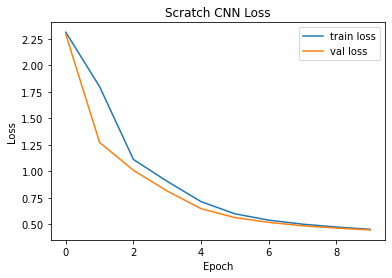

In [80]:
# visualiser l'apprentissage
plot_loss(conv)

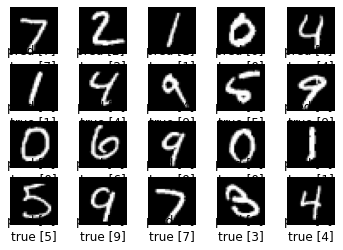

In [83]:
for i in range(20):
    pred = conv.predict(X_test[i][None,...])
    true = y_test[i]
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[i].reshape(28,28), 'gray')
    plt.title('pred {} \ntrue [{}]'.format(pred, true), y=-0.45)
    plt.axis('off')